In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error as mse
import os
 
import physt
from physt import h1, h2, histogramdd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.signal import savgol_filter

ModuleNotFoundError: No module named 'physt'

In [ ]:
def hampel(vals_orig, k=3, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''

    #Make copy so original not edited
    vals_orig = pd.Series(vals_orig[:,0])
    vals = vals_orig.copy()

    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)

    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''

    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [2]:
def normalize(quant, minn, maxx):
    a = -1
    b = 1
    t = a + ( quant - minn) * ((b - a) / (maxx - minn))
    return t.astype(np.float32)

In [17]:
lm10 = sio.loadmat('../../datasets/RawData/OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


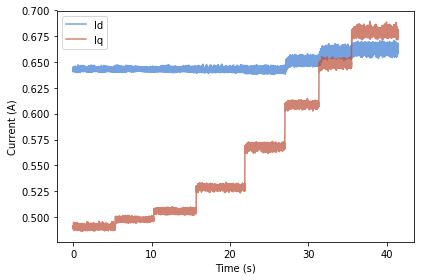

In [6]:
plt.plot(lm10['Time_I'],current1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_I'],current2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_current.pdf', dpi=500, format='pdf', pad_inches=0)

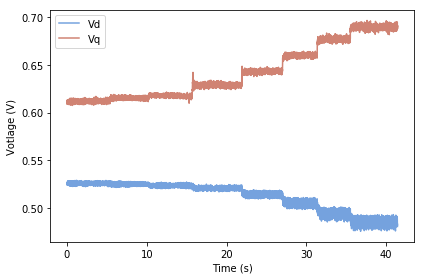

In [7]:
plt.plot(lm10['Time_VSpdTq'],voltage1, label='Vd', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'],voltage2, label='Vq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Votlage (V)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_votlage.pdf', dpi=500, format='pdf', pad_inches=0)

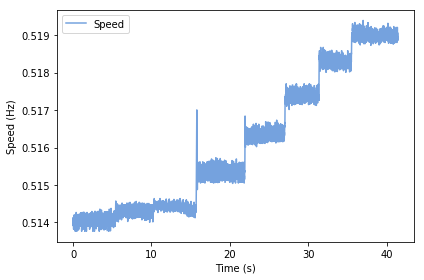

In [8]:
plt.plot(lm10['Time_VSpdTq'],speed, label='Speed', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_speed.pdf', dpi=500, format='pdf', pad_inches=0)

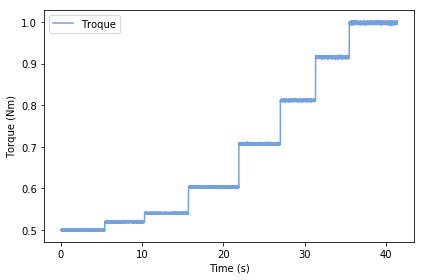

In [9]:
plt.plot(lm10['Time_VSpdTq'],torque, label='Troque', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [23]:
voltage1_r = normalize(hampel(lm10['VdRef_V']), -200, 200)
voltage2_r = normalize(hampel(lm10['VqRef_V']), -500, 500)
speed_r = normalize(hampel(lm10['Speed_Hz']) * 2 * math.pi, -700, 700)
current1_r = normalize(hampel(lm10['IdMeas_A']), -20, 20)
current2_r = normalize(hampel(lm10['IqMeas_A']), -30, 30)
torque_r = normalize(hampel(lm10['Torque_PercTnom']) / 100 * 25, -70, 70)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


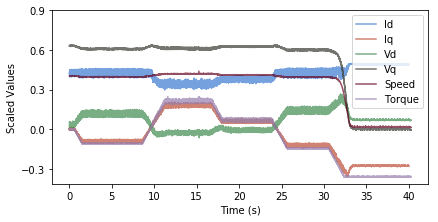

In [24]:
s = 0
e = 10000
plt.figure(figsize=(6,3))
plt.plot(lm10['Time_I'][s:e],current1_r[s:e], label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_I'][s:e],current2_r[s:e], label='Iq', color='#bc4e38', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage1_r[s:e], label='Vd', color='#418C51', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage2_r[s:e], label='Vq', color='#3A3B33', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],speed_r[s:e], label='Speed', color='#650521', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],torque_r[s:e], label='Torque', color='#947CAD', alpha=0.7)
plt.yticks(np.arange(-0.3,1,step=0.3))
# plt.xticks(np.arange(0.0,22.0,step=2.0))
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Scaled Values')
plt.savefig('../../docs/ICML/figures/lm45_torquesteps.pdf', dpi=500, format='pdf', pad_inches=0)

In [25]:
Current = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Current.mat')
Voltage = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Voltage.mat')
Time = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Time.mat')
Speed = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Speed.mat')
Torque = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Torque.mat')

In [26]:
voltage1 = normalize(Voltage['voltage'][:, 0], -200, 200)
voltage2 = normalize(Voltage['voltage'][: ,1], -500, 500)
speed = normalize(Speed['speed'][:, 0], -700, 700)
current1 = normalize(Current['current'][:, 0], -20, 20)
current2 = normalize(Current['current'][:, 1], -30, 30)
torque = normalize(Torque['torque'][:, 0], -70, 70)

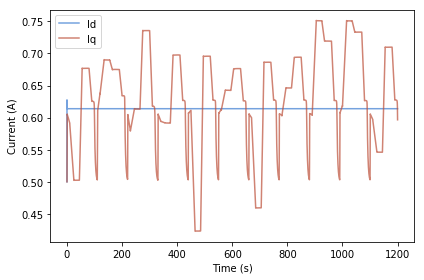

In [15]:
plt.plot(Time['time'],current1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'],current2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_current_100.pdf', dpi=500, format='pdf', pad_inches=0)

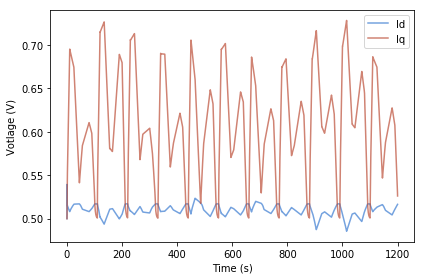

In [17]:
plt.plot(Time['time'],voltage1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'],voltage2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Votlage (V)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_voltage.pdf', dpi=500, format='pdf', pad_inches=0)

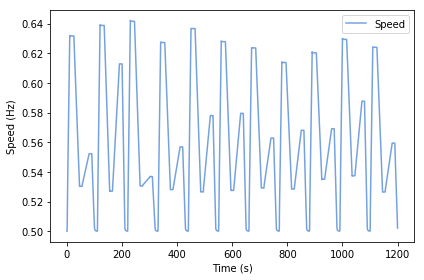

In [18]:
plt.plot(Time['time'],speed, label='Speed', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_speed.pdf', dpi=500, format='pdf', pad_inches=0)

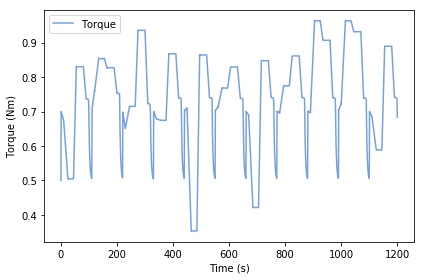

In [19]:
plt.plot(Time['time'],torque, label='Torque', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [28]:
Current = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Current.mat')
Time = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Time.mat')
Torque = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Torque.mat')
Voltage = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Voltage.mat')
Speed = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Speed.mat')

In [29]:
voltage1 = normalize(Voltage['voltage'][:, 0], -200, 200)
voltage2 = normalize(Voltage['voltage'][: ,1], -500, 500)
speed = normalize(Speed['speed'][:, 0], -700, 700)
current1 = normalize(Current['current'][:, 0], -20, 20)
current2 = normalize(Current['current'][:, 1], -30, 30)
torque = normalize(Torque['torque'][:, 0], -70, 70)
time = Time['time'][:, 0]

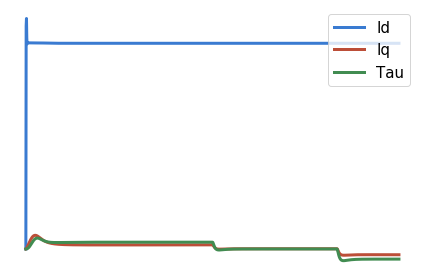

In [35]:
plt.plot(current1[:1200], label='Id', color='#3a7bd1', linewidth=3)
plt.plot(current2[:1200], label='Iq', color='#bc4e38', linewidth=3)
plt.plot(torque[:1200], label='Tau', color='#418C51', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/out.png', dpi=500, format='png', pad_inches=0, quality=100, transparent=True)

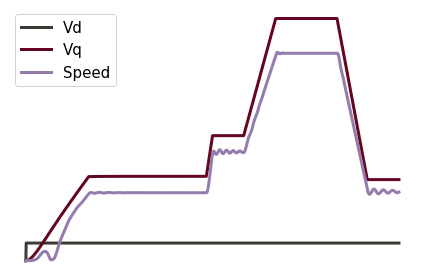

In [24]:
plt.plot(voltage1[:1200], label='Vd', color='#3A3B33', linewidth=3)
plt.plot(voltage2[:1200], label='Vq', color='#650521', linewidth=3)
plt.plot(speed[:1200], label='Speed', color='#947CAD', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/inp.png', dpi=500, format='png', pad_inches=0, quality=100, transparent=True)

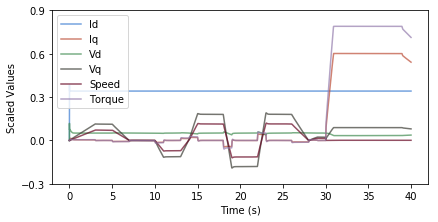

In [30]:
s = 0
e = 8000
plt.figure(figsize=(6,3))
plt.plot(Time['time'][s:e],current1[s:e], label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'][s:e],current2[s:e], label='Iq', color='#bc4e38', alpha=0.7)
plt.plot(Time['time'][s:e],voltage1[s:e], label='Vd', color='#418C51', alpha=0.7)
plt.plot(Time['time'][s:e],voltage2[s:e], label='Vq', color='#3A3B33', alpha=0.7)
plt.plot(Time['time'][s:e],speed[s:e], label='Speed', color='#650521', alpha=0.7)
plt.plot(Time['time'][s:e],torque[s:e], label='Torque', color='#947CAD', alpha=0.7)
plt.yticks(np.arange(-0.3,1,step=0.3))
# plt.xticks(np.arange(0.0,22.0,step=2.0))
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Scaled Values')
plt.savefig('../../docs/ICML/figures/sim.pdf', dpi=500, format='pdf', pad_inches=0)

In [111]:
# torque = [0 for x in range(int(5/0.005))] + [5 for x in range(int(5/0.005))] + [10 for x in range(int(5/0.005))] + [25 for x in range(int(5/0.005))] + [50 for x in range(int(5/0.005))] + [75 for x in range(int(5/0.005))] + [100 for x in range(int(5/0.005))] + [120 for x in range(int(5/0.005))]
torque = [5 for x in range(int(40/0.005))]
# torque = np.asarray(torque) / 100 * 25
# speed = [68 for x in range(int(40/0.005))] 
speed = [0 for x in range(int(4/0.005))]  
speed += [1 for x in range(int(4/0.005))]
speed += [3 for x in range(int(4/0.005))]
speed += [5 for x in range(int(4/0.005))]
speed += [10 for x in range(int(4/0.005))]
speed += [20 for x in range(int(4/0.005))]
speed += [30 for x in range(int(4/0.005))]
speed += [40 for x in range(int(3/0.005))]
speed += [50 for x in range(int(3/0.005))]
speed += [75 for x in range(int(3/0.005))]
speed += [100 for x in range(int(3/0.005))]

print (len(speed),len(torque))
speed = np.asarray(speed) * 2 * math.pi
time = []

for x in range(len(speed)):
    time.append(x * 0.005)

8000 8000


In [112]:
sio.savemat('../../datasets/RefSynthData/0-100Hz.mat',
            {'Speed':np.asarray(speed),
            't':np.asarray(time),
            'Kvalv':np.asarray(torque)})

In [40]:
Data8Feb = sio.loadmat('../../datasets/RefSynthData/Data8Feb2019.mat')
time = Data8Feb['t'][0]
speed = Data8Feb['Speed'][0]
torque = Data8Feb['Kvalv'][0]
print (time.shape)

(3596,)


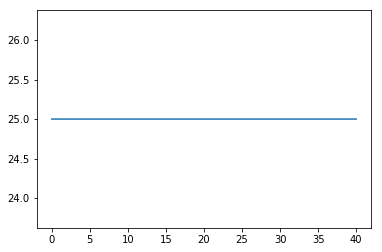

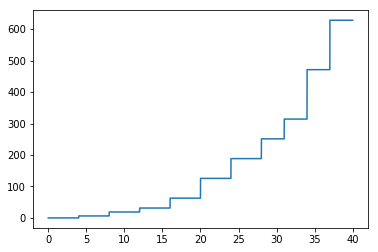

In [109]:
plt.plot(time, torque)
plt.show()
plt.plot(time, speed)
plt.show()

In [42]:
hampel(lm10['Torque_PercTnom'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


(10231,)

In [60]:
lm10['Speed_Hz'][0] * 2 * math.pi, lm10['Speed_Hz'][-1] * 2 * math.pi

(array([62.12622191]), array([83.26639464]))

In [78]:
lm10['Torque_PercTnom'][9200:9210]

array([[119.06738281],
       [119.87304688],
       [118.77441406],
       [118.53027344],
       [120.1171875 ],
       [119.36035156],
       [119.43359375],
       [120.33691406],
       [119.62890625],
       [119.75097656]])

In [89]:
data_raw = sio.loadmat('../../results_raw/LM20_TorqueSteps.mat')
data_sim = sio.loadmat('../../results_sim/LM20_TorqueSteps.mat')

In [80]:
data.keys()

dict_keys(['time', 'torque_pred', 'voltage2', 'current2_pred', 'current2_true', '__globals__', '__version__', 'voltage1', 'speed', 'torque_true', '__header__', 'current1_pred', 'current1_true'])

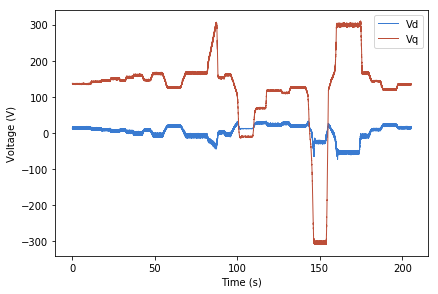

In [81]:
plt.plot(data_raw['time'][0,:],data_raw['voltage1'][0], label='Vd', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['voltage2'][0], label='Vq', color='#bc4e38', linewidth=1)
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.savefig('../../docs/ICML/figures/res_volt.pdf', dpi=500, format='pdf', pad_inches=0)

No handles with labels found to put in legend.


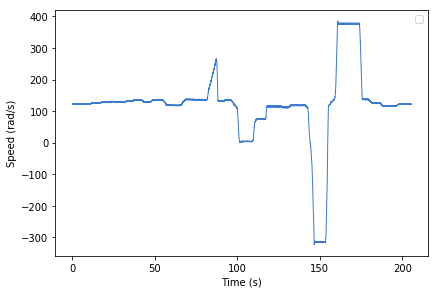

In [82]:
plt.plot(data['time'][0,:],data['speed'][0], color='#3a7bd1', linewidth=1)
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.savefig('../../docs/ICML/figures/res_speed.pdf', dpi=500, format='pdf', pad_inches=0)

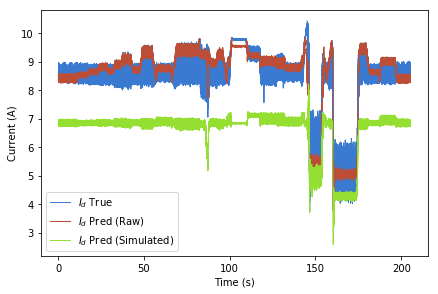

In [107]:
plt.plot(data_raw['time'][0,:],data_raw['current1_true'][0], label=r'$I_d$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['current1_pred'][0], label=r'$I_d$ Pred (Raw)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['current1_pred'][0], label=r'$I_d$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.savefig('../../docs/ICML/figures/res_sim_curr1.pdf', dpi=500, format='pdf', pad_inches=0)

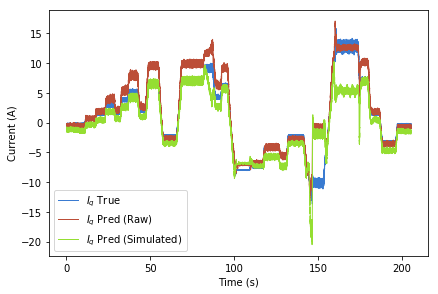

In [108]:
plt.plot(data_raw['time'][0,:],data_raw['current2_true'][0], label=r'$I_q$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['current2_pred'][0], label=r'$I_q$ Pred (Raw)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['current2_pred'][0], label=r'$I_q$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.savefig('../../docs/ICML/figures/res_sim_curr2.pdf', dpi=500, format='pdf', pad_inches=0)

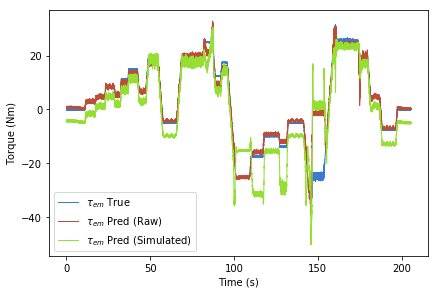

In [109]:
plt.plot(data_raw['time'][0,:],data_raw['torque_true'][0], label=r'$\tau_{em}$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['torque_pred'][0], label=r'$\tau_{em}$ Pred (Raw)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['torque_pred'][0], label=r'$\tau_{em}$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.savefig('../../docs/ICML/figures/res_sim_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [3]:
def sc(signal):
    return np.sum(abs(signal[1:] - signal[:-1]))

In [4]:
results = os.listdir('../../results_raw/')

In [5]:
curr1_sc_mse_raw = []
curr2_sc_mse_raw = []
torque_sc_mse_raw = []

curr1_sc_mse_sim = []
curr2_sc_mse_sim = []
torque_sc_mse_sim = []


for result in results:
    if 'mat' in result:
        data_raw = sio.loadmat('../../results_raw/' + result)
        data_sim = sio.loadmat('../../results_sim/' + result)
        
        for i in range(0,data_raw['current1_true'].shape[1],1):
            if i+101 < data_raw['current1_true'].shape[1]:
                scv_raw = sc(data_raw['current1_true'][0,i:i+100])
                msev_raw = mse(data_raw['current1_true'][0,i:i+100],data_raw['current1_pred'][0,i:i+100])
                curr1_sc_mse_raw.append([scv_raw,msev_raw])
                
                scv_sim = sc(data_sim['current1_true'][0,i:i+100])
                msev_sim = mse(data_sim['current1_true'][0,i:i+100],data_sim['current1_pred'][0,i:i+100])
                curr1_sc_mse_sim.append([scv_sim,msev_sim])


        for i in range(0,data_raw['current2_true'].shape[1],1):
            if i+101 < data_raw['current2_true'].shape[1]: 
                scv_raw = sc(data_raw['current2_true'][0,i:i+100])
                msev_raw = mse(data_raw['current2_true'][0,i:i+100],data_raw['current2_pred'][0,i:i+100])
                curr2_sc_mse_raw.append([scv_raw,msev_raw])
                
                scv_sim = sc(data_sim['current2_true'][0,i:i+100])
                msev_sim = mse(data_sim['current2_true'][0,i:i+100],data_sim['current2_pred'][0,i:i+100])
                curr2_sc_mse_sim.append([scv_sim,msev_sim])

        for i in range(0,data_raw['torque_true'].shape[1],1):
            if i+101 < data_raw['torque_true'].shape[1]:
                scv_raw = sc(data_raw['torque_true'][0,i:i+100])
                msev_raw = mse(data_raw['torque_true'][0,i:i+100],data_raw['torque_pred'][0,i:i+100])
                torque_sc_mse_raw.append([scv_raw,msev_raw])
                
                scv_sim = sc(data_sim['torque_true'][0,i:i+100])
                msev_sim = mse(data_sim['torque_true'][0,i:i+100],data_sim['torque_pred'][0,i:i+100])
                torque_sc_mse_sim.append([scv_sim,msev_sim])

In [6]:
curr1_sc_mse_raw = np.asarray(curr1_sc_mse_raw)
curr2_sc_mse_raw = np.asarray(curr2_sc_mse_raw)
torque_sc_mse_raw = np.asarray(torque_sc_mse_raw)

curr1_sc_mse_sim = np.asarray(curr1_sc_mse_sim)
curr2_sc_mse_sim = np.asarray(curr2_sc_mse_sim)
torque_sc_mse_sim = np.asarray(torque_sc_mse_sim)

In [8]:
curr1_sc_mse_raw = np.sort(curr1_sc_mse_raw, axis=0)
curr2_sc_mse_raw = np.sort(curr2_sc_mse_raw, axis=0)
torque_sc_mse_raw = np.sort(torque_sc_mse_raw, axis=0)

curr1_sc_mse_sim = np.sort(curr1_sc_mse_sim, axis=0)
curr2_sc_mse_sim = np.sort(curr2_sc_mse_sim, axis=0)
torque_sc_mse_sim = np.sort(torque_sc_mse_sim, axis=0)

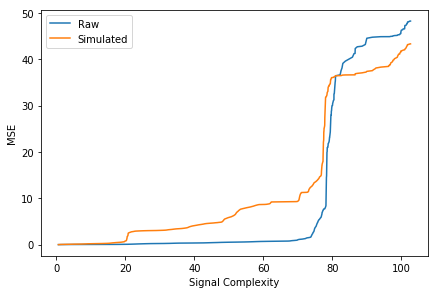

In [176]:
# plt.plot(curr1_sc_mse[:,0],curr1_sc_mse[:,1], marker='o', markersize=0.7)
# plt.legend()
# plt.tight_layout()
# plt.xlabel('Signal Complexity')
# plt.ylabel('MSE')
# plt.savefig('../../docs/ICML/figures/sc_mse_curr1.pdf', dpi=500, format='pdf', pad_inches=0)

# fig, ax = plt.subplots(figsize=(8, 7))
# h_2_raw = h2(curr1_sc_mse_raw[:,0], curr1_sc_mse_raw[:,1], 100)
# h_2_raw.plot("map", lw=0, alpha=1, cmap="Blues", ax=ax, show_zero=False, label='Raw', show_colorbar=False)
# h_2_sim = h2(curr1_sc_mse_sim[:,0], curr1_sc_mse_sim[:,1], 100)
# h_2_sim.plot("map", lw=0, alpha=1, cmap="Oranges", ax=ax,  show_zero=False, label='Simulated', show_colorbar=False)
plt.plot(curr1_sc_mse_raw[:,0], curr1_sc_mse_raw[:,1], label='Raw')
plt.plot(curr1_sc_mse_sim[:,0], curr1_sc_mse_sim[:,1], label='Simulated')
plt.legend()
plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('MSE')
plt.savefig('../../docs/ICML/figures/sc_mse_curr1.pdf', dpi=500, format='pdf', pad_inches=0)

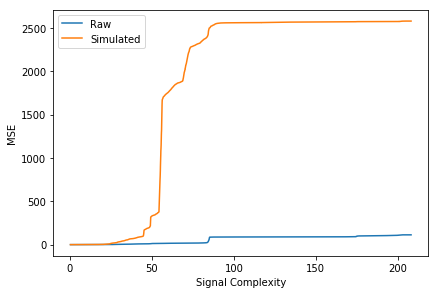

In [177]:
# fig, ax = plt.subplots(figsize=(8, 7))
# h_2_raw = h2(curr2_sc_mse_raw[:,0], curr2_sc_mse_raw[:,1], 10)
# h_2_raw.plot("map", lw=0, alpha=1, cmap="Blues", ax=ax, show_zero=False, label='Raw', show_colorbar=False)
# h_2_sim = h2(curr2_sc_mse_sim[:,0], curr2_sc_mse_sim[:,1], 10)
# h_2_sim.plot("map", lw=0, alpha=1, cmap="Oranges", ax=ax,  show_zero=False, label='Simulated', show_colorbar=False)
plt.plot(curr2_sc_mse_raw[:,0], curr2_sc_mse_raw[:,1], label='Raw')
plt.plot(curr2_sc_mse_sim[:,0], curr2_sc_mse_sim[:,1], label='Simulated')
plt.legend()
plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('MSE')
plt.savefig('../../docs/ICML/figures/sc_mse_curr2.pdf', dpi=500, format='pdf', pad_inches=0)

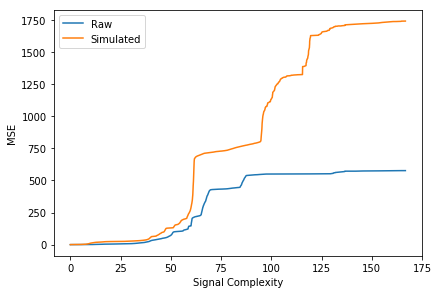

In [180]:
# fig, ax = plt.subplots(figsize=(8, 7))
# h_2_raw = h2(torque_sc_mse_raw[:,0], torque_sc_mse_raw[:,1], 10)
# h_2_raw.plot("map", lw=0, alpha=1, cmap="Blues", ax=ax, show_zero=False, label='Raw', show_colorbar=False)
# h_2_sim = h2(torque_sc_mse_sim[:,0], torque_sc_mse_sim[:,1], 10)
# h_2_sim.plot("map", lw=0, alpha=1, cmap="Oranges", ax=ax,  show_zero=False, label='Simulated', show_colorbar=False)
plt.plot(torque_sc_mse_raw[:,0], torque_sc_mse_raw[:,1], label='Raw')
plt.plot(torque_sc_mse_sim[:,0], torque_sc_mse_sim[:,1], label='Simulated')
plt.legend()
plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('MSE')
plt.savefig('../../docs/ICML/figures/sc_mse_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [182]:
torque_sc_mse[-10:,0], torque_sc_mse[-10:,1]

(array([150.13437, 153.42416, 155.09653, 157.84923, 159.77792, 160.57748,
        162.1766 , 164.55087, 164.75227, 166.7176 ], dtype=float32),
 array([574.2151 , 575.0965 , 575.1737 , 576.01385, 576.132  , 576.3423 ,
        576.3463 , 576.8925 , 576.91315, 576.99164], dtype=float32))